In [488]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [489]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [490]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078040 entries, 0 to 2078039
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 31.7 MB


# reduce to 1 million events

In [491]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [492]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,1619,2.22,1.619
1,1620,2.22,1.620
2,1621,2.22,1.621
3,1618,2.22,1.618
4,1624,2.22,1.624
...,...,...,...
999995,1568,2.30,1.568
999996,1567,2.30,1.567
999997,1574,2.29,1.574
999998,19152,0.19,19.152


In [493]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [494]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [495]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26082324367000

### Calcul de la date de base = now - cumul_interval

In [496]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 6, 3, 12, 44, 26, 964575)

In [497]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [498]:
conso_data.iloc[0]


Interval     1619.000000
kWh             2.220000
sec             1.619000
Wh           2223.594812
cumul(ms)    1619.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [499]:
base

datetime.datetime(2024, 6, 3, 12, 44, 26, 964575)

## créer les dates

In [500]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-06-03 12:44:28.583575
1        2024-06-03 12:44:30.203575
2        2024-06-03 12:44:31.824575
3        2024-06-03 12:44:33.442575
4        2024-06-03 12:44:35.066575
                    ...            
999995   2025-04-01 09:49:00.879575
999996   2025-04-01 09:49:02.446575
999997   2025-04-01 09:49:04.020575
999998   2025-04-01 09:49:23.172575
999999   2025-04-01 09:49:51.331575
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [501]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,1619,2.22,1.619,2223.594812,1619,2024-06-03 12:44:28.583575,03/06/24
1,1620,2.22,1.620,2222.222222,3239,2024-06-03 12:44:30.203575,03/06/24
2,1621,2.22,1.621,2220.851326,4860,2024-06-03 12:44:31.824575,03/06/24
3,1618,2.22,1.618,2224.969098,6478,2024-06-03 12:44:33.442575,03/06/24
4,1624,2.22,1.624,2216.748768,8102,2024-06-03 12:44:35.066575,03/06/24
...,...,...,...,...,...,...,...
999995,1568,2.30,1.568,2295.918367,26082273915,2025-04-01 09:49:00.879575,01/04/25
999996,1567,2.30,1.567,2297.383535,26082275482,2025-04-01 09:49:02.446575,01/04/25
999997,1574,2.29,1.574,2287.166455,26082277056,2025-04-01 09:49:04.020575,01/04/25
999998,19152,0.19,19.152,187.969925,26082296208,2025-04-01 09:49:23.172575,01/04/25


### save conso_data with dates

In [502]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [503]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('01/04/25', 1, 4, 2025)

In [504]:
here = now.strftime('%H:%M:%S')
here

'09:50:04'

In [505]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [506]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1083 entries, 998917 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1083 non-null   int64         
 1   kWh        1083 non-null   float64       
 2   sec        1083 non-null   float64       
 3   Wh         1083 non-null   float64       
 4   cumul(ms)  1083 non-null   int64         
 5   dates      1083 non-null   datetime64[ns]
 6   days       1083 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 67.7+ KB


In [507]:
end = time.time()
print(end - start)

16.72076964378357


### grouped by days

In [508]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [509]:
data = list(df_grp['kWh'])
print(data)

[1.806, 3.313, 3.487, 3.179, 2.923, 3.422, 3.169, 3.262, 3.772, 3.371, 3.332, 3.101, 2.939, 3.699, 3.261, 3.108, 3.207, 3.405, 2.951, 3.015, 3.537, 3.601, 3.496, 3.029, 2.982, 2.087, 2.082, 2.095, 2.081, 2.086, 2.079, 2.083, 2.076, 2.079, 3.573, 3.196, 3.408, 3.849, 3.509, 3.879, 3.546, 3.544, 3.727, 3.488, 3.398, 3.269, 3.476, 3.296, 3.723, 3.689, 3.551, 3.641, 3.401, 3.24, 3.23, 2.786, 3.078, 3.654, 3.77, 3.829, 3.004, 3.339, 3.356, 3.507, 3.651, 3.671, 3.478, 3.804, 3.858, 3.692, 4.438, 4.21, 3.896, 3.924, 4.01, 3.817, 3.831, 3.711, 3.286, 3.932, 3.954, 4.436, 3.767, 4.141, 3.772, 3.969, 3.783, 3.949, 3.729, 3.58, 3.501, 3.683, 3.526, 4.122, 3.707, 3.444, 3.529, 3.272, 2.401, 1.795, 1.792, 1.793, 1.796, 2.497, 1.841, 1.788, 1.791, 1.791, 1.82, 1.822, 1.815, 1.817, 1.818, 1.818, 1.816, 1.812, 1.785, 1.787, 1.785, 1.786, 1.783, 1.796, 1.789, 1.789, 1.785, 1.796, 1.802, 1.795, 1.804, 1.796, 1.785, 1.79, 1.784, 1.791, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.797, 2.835, 3.994, 3.641, 3

In [510]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [511]:
end = time.time()
print(end - start)

16.980671644210815


### plot function by day
#### show('dd/mm/yy')

In [512]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


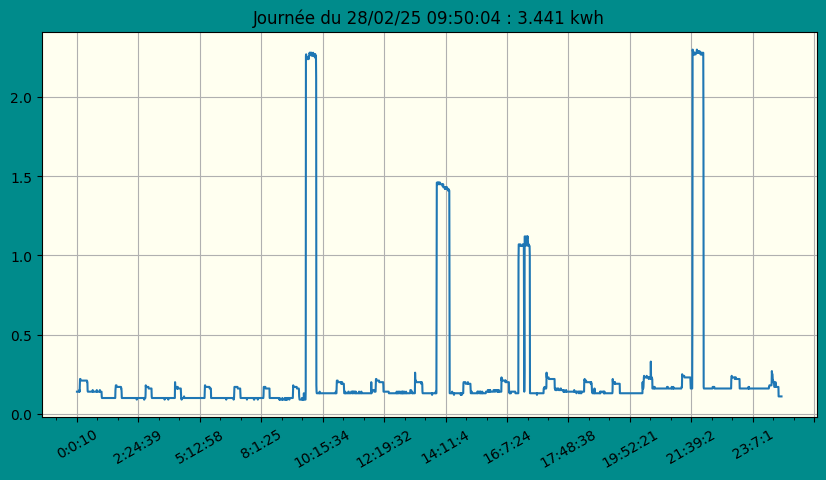

In [513]:
show('28/02/25')

In [514]:
end = time.time()
print(end - start)

18.144203901290894


### 1 kWh window in data of one day
#### df = conso_day

In [515]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998917,35300,0.10,35.300,101.983003,26046961594,2025-04-01 00:00:28.558575,01/04/25
998918,32974,0.11,32.974,109.176927,26046994568,2025-04-01 00:01:01.532575,01/04/25
998919,33826,0.11,33.826,106.427009,26047028394,2025-04-01 00:01:35.358575,01/04/25
998920,34680,0.10,34.680,103.806228,26047063074,2025-04-01 00:02:10.038575,01/04/25
998921,34687,0.10,34.687,103.785280,26047097761,2025-04-01 00:02:44.725575,01/04/25
...,...,...,...,...,...,...,...
999995,1568,2.30,1.568,2295.918367,26082273915,2025-04-01 09:49:00.879575,01/04/25
999996,1567,2.30,1.567,2297.383535,26082275482,2025-04-01 09:49:02.446575,01/04/25
999997,1574,2.29,1.574,2287.166455,26082277056,2025-04-01 09:49:04.020575,01/04/25
999998,19152,0.19,19.152,187.969925,26082296208,2025-04-01 09:49:23.172575,01/04/25


In [516]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [517]:
df = conso_day
len(df)

1083

In [518]:
period()  # first kWh

2025-04-01 00:00:28.558575	2025-04-01 09:30:49.389575	9h 30m 20s 	1000


In [519]:
period(p=2) # second period

2025-04-01 09:30:49.389575	2025-04-01 09:49:51.331575	0h 19m 1s 	83


In [520]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.29115
dtype: float64

In [521]:
end = time.time()
print(end - start)

18.397440910339355


## mean for data grouped by days

In [522]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [523]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.083)

# conso by date


In [524]:
# select day
day = today

#day = '16/08/24'
day

'01/04/25'

In [525]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998917,35300,0.10,35.300,101.983003,26046961594,2025-04-01 00:00:28.558575,01/04/25
998918,32974,0.11,32.974,109.176927,26046994568,2025-04-01 00:01:01.532575,01/04/25
998919,33826,0.11,33.826,106.427009,26047028394,2025-04-01 00:01:35.358575,01/04/25
998920,34680,0.10,34.680,103.806228,26047063074,2025-04-01 00:02:10.038575,01/04/25
998921,34687,0.10,34.687,103.785280,26047097761,2025-04-01 00:02:44.725575,01/04/25
...,...,...,...,...,...,...,...
999995,1568,2.30,1.568,2295.918367,26082273915,2025-04-01 09:49:00.879575,01/04/25
999996,1567,2.30,1.567,2297.383535,26082275482,2025-04-01 09:49:02.446575,01/04/25
999997,1574,2.29,1.574,2287.166455,26082277056,2025-04-01 09:49:04.020575,01/04/25
999998,19152,0.19,19.152,187.969925,26082296208,2025-04-01 09:49:23.172575,01/04/25


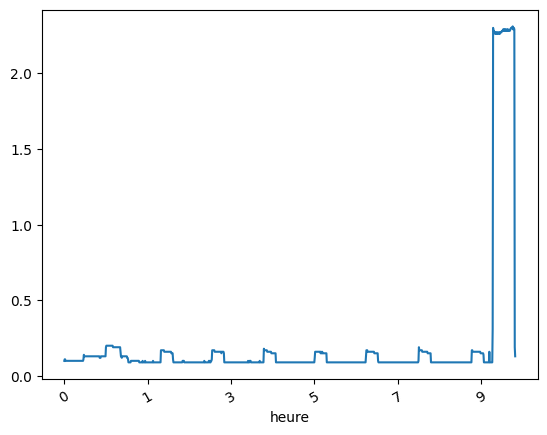

In [526]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [527]:
end = time.time()
print(end - start)

18.938772916793823


### grouped by 'heure'

In [528]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1083 entries, 998917 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1083 non-null   int64         
 1   kWh        1083 non-null   float64       
 2   sec        1083 non-null   float64       
 3   Wh         1083 non-null   float64       
 4   cumul(ms)  1083 non-null   int64         
 5   dates      1083 non-null   datetime64[ns]
 6   days       1083 non-null   object        
 7   heure      1083 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 76.1+ KB


In [529]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,35300,0.10,35.300,101.983003,26046961594,2025-04-01 00:00:28.558575,01/04/25
0,32974,0.11,32.974,109.176927,26046994568,2025-04-01 00:01:01.532575,01/04/25
0,33826,0.11,33.826,106.427009,26047028394,2025-04-01 00:01:35.358575,01/04/25
0,34680,0.10,34.680,103.806228,26047063074,2025-04-01 00:02:10.038575,01/04/25
0,34687,0.10,34.687,103.785280,26047097761,2025-04-01 00:02:44.725575,01/04/25
...,...,...,...,...,...,...,...
9,1568,2.30,1.568,2295.918367,26082273915,2025-04-01 09:49:00.879575,01/04/25
9,1567,2.30,1.567,2297.383535,26082275482,2025-04-01 09:49:02.446575,01/04/25
9,1574,2.29,1.574,2287.166455,26082277056,2025-04-01 09:49:04.020575,01/04/25


In [530]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [531]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    125
1    104
2    106
3    105
4    104
5    103
6    101
7     92
8    104
9    139
Name: kWh, dtype: int64

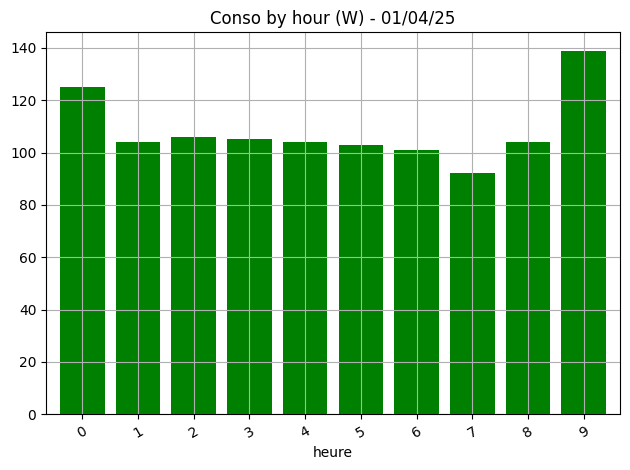

In [532]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [533]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 03/06/24 to 01/04/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [534]:
# give the periods of 1 kwh in a day
period()

2025-04-01 00:00:28.558575	2025-04-01 09:30:49.389575	9h 30m 20s 	1000


In [535]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-04-01 00:00:28.558575'),
 Timestamp('2025-04-01 09:31:12.747575'))

In [536]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [537]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [538]:
df_grp.head()


,kWh
days,
03/06/24,1.806
04/06/24,3.313
05/06/24,3.487
06/06/24,3.179
07/06/24,2.923


In [539]:
df_grp.tail()


,kWh
days,
28/03/25,3.489
29/03/25,3.842
30/03/25,4.002
31/03/25,3.411
01/04/25,1.083


In [540]:
end = time.time()
print(end - start)

19.749308109283447


# plot les 100 derniers jours


In [541]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.66738
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

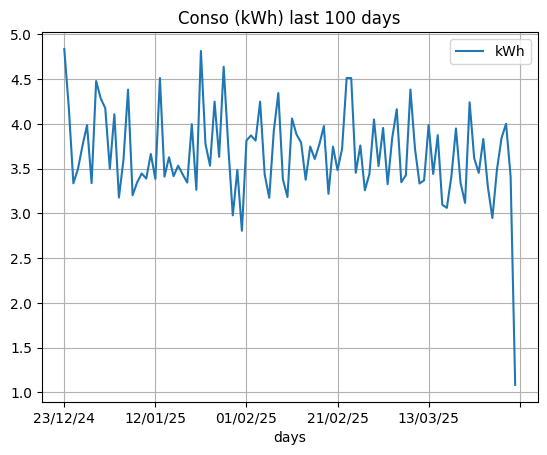

In [542]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [543]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.083
max,4.838


In [544]:
end = time.time()
print(end - start)

20.315247058868408


Text(0.5, 1.0, 'Last month conso by day')

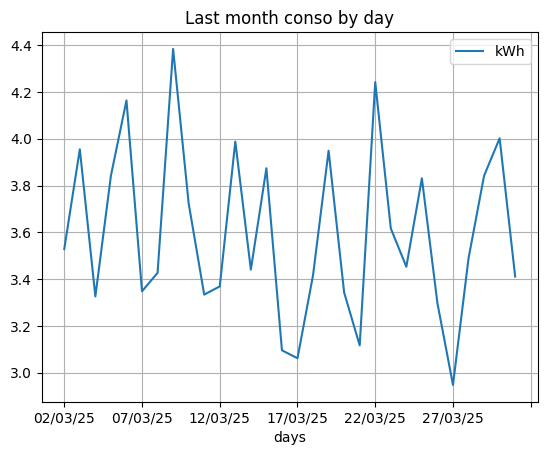

In [545]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [546]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/03/25 4.384
Min : 27/03/25 2.948


In [547]:

tranches = len(df)//1000
tranches+1


2

In [548]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-04-01 00:00:28.558575	2025-04-01 09:30:49.389575	9h 30m 20s 	1000
2025-04-01 09:30:49.389575	2025-04-01 09:49:51.331575	0h 19m 1s 	83


('09:50:04', 1.083, 1083)

In [549]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1083 entries, 998917 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1083 non-null   int64         
 1   kWh        1083 non-null   float64       
 2   sec        1083 non-null   float64       
 3   Wh         1083 non-null   float64       
 4   cumul(ms)  1083 non-null   int64         
 5   dates      1083 non-null   datetime64[ns]
 6   days       1083 non-null   object        
 7   heure      1083 non-null   object        
 8   hours      1083 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 84.6+ KB


In [550]:
conso_hours['heure'], conso_hours['hours']

(998917    0
 998918    0
 998919    0
 998920    0
 998921    0
          ..
 999995    9
 999996    9
 999997    9
 999998    9
 999999    9
 Name: heure, Length: 1083, dtype: object,
 998917    00
 998918    00
 998919    00
 998920    00
 998921    00
           ..
 999995    09
 999996    09
 999997    09
 999998    09
 999999    09
 Name: hours, Length: 1083, dtype: object)

In [551]:
end = time.time()
print(end - start)

20.908023834228516


# select number of days to display


In [552]:
span = 30
#df_grp.tail(span)

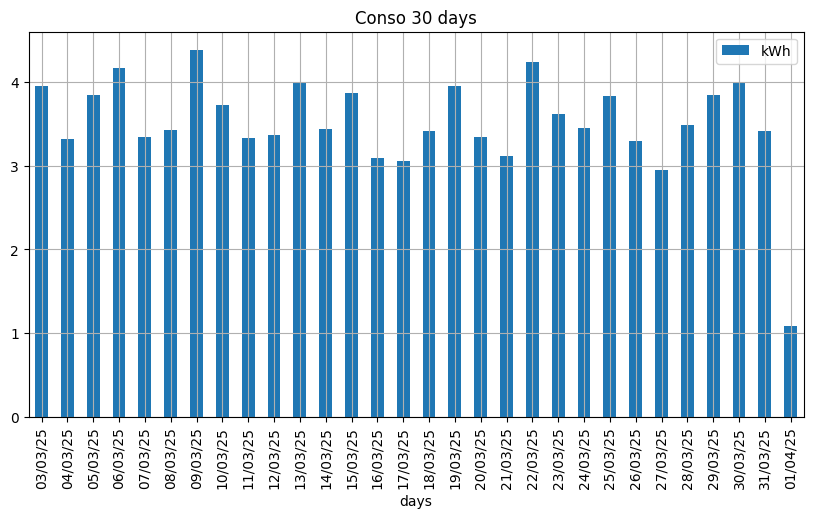

In [553]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


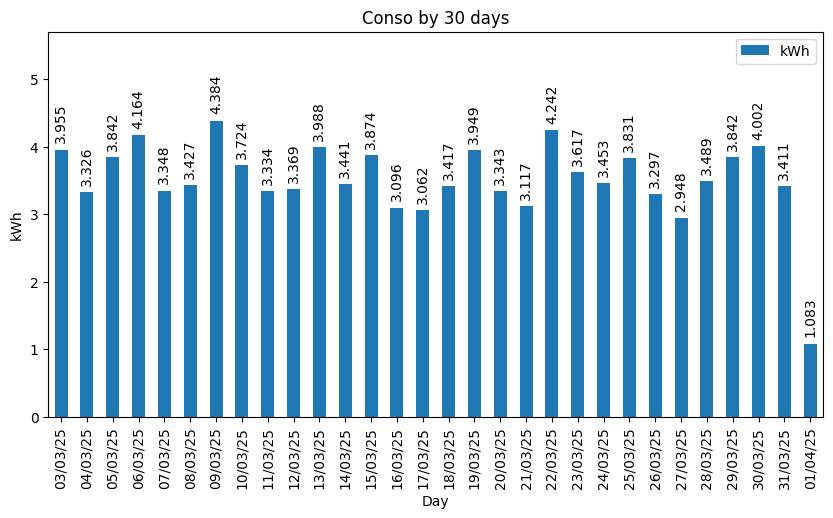

In [554]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [555]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
03/03/25    3.955
04/03/25    3.326
05/03/25    3.842
06/03/25    4.164
07/03/25    3.348
08/03/25    3.427
09/03/25    4.384
10/03/25    3.724
11/03/25    3.334
12/03/25    3.369
13/03/25    3.988
14/03/25    3.441
15/03/25    3.874
16/03/25    3.096
17/03/25    3.062
18/03/25    3.417
19/03/25    3.949
20/03/25    3.343
21/03/25    3.117
22/03/25    4.242
23/03/25    3.617
24/03/25    3.453
25/03/25    3.831
26/03/25    3.297
27/03/25    2.948
28/03/25    3.489
29/03/25    3.842
30/03/25    4.002
31/03/25    3.411
01/04/25    1.083
Name: kWh, dtype: float64

In [556]:
x_labels=df_grp.tail(span).index
x_labels

Index(['03/03/25', '04/03/25', '05/03/25', '06/03/25', '07/03/25', '08/03/25',
       '09/03/25', '10/03/25', '11/03/25', '12/03/25', '13/03/25', '14/03/25',
       '15/03/25', '16/03/25', '17/03/25', '18/03/25', '19/03/25', '20/03/25',
       '21/03/25', '22/03/25', '23/03/25', '24/03/25', '25/03/25', '26/03/25',
       '27/03/25', '28/03/25', '29/03/25', '30/03/25', '31/03/25', '01/04/25'],
      dtype='object', name='days')

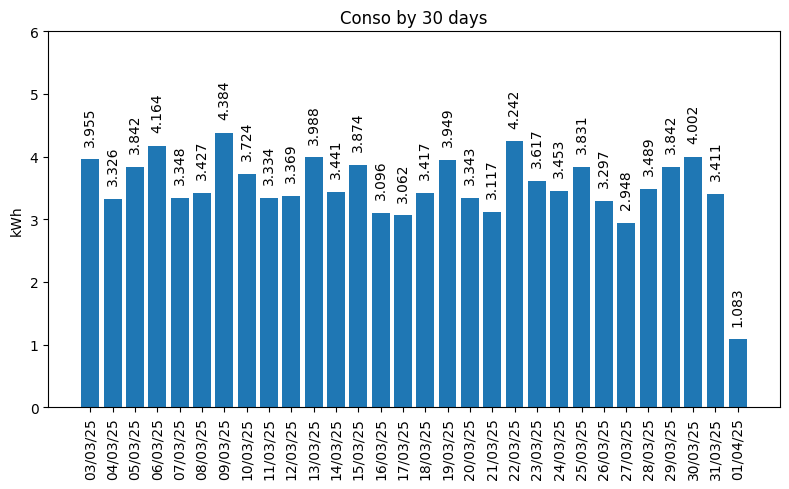

In [557]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [558]:
end = time.time()
print(end - start)

24.179072618484497


In [559]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

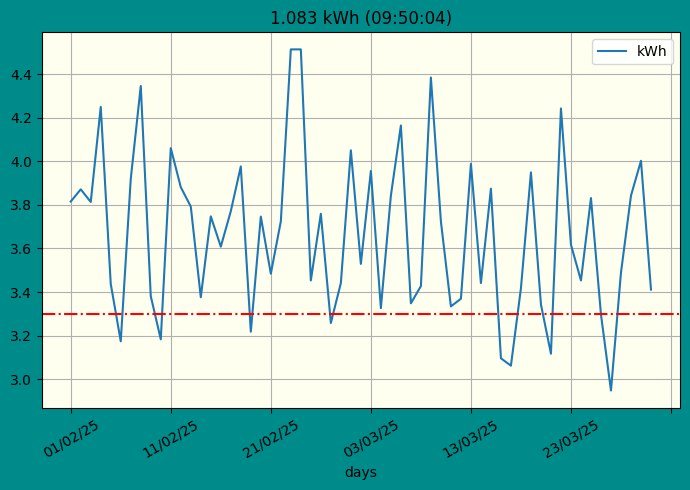

In [560]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

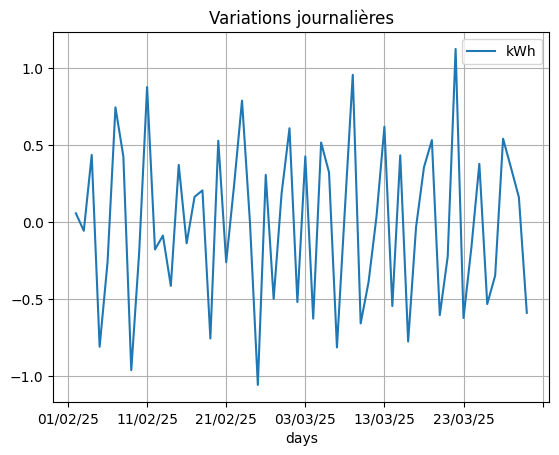

In [561]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [562]:
end = time.time()
print(end - start)

25.186543464660645


# Data from 21/08/23

In [563]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,1619,2.22,1.619,2223.594812,1619,2024-06-03 12:44:28.583575,03/06/24,12,2024-06,03
1,1620,2.22,1.620,2222.222222,3239,2024-06-03 12:44:30.203575,03/06/24,12,2024-06,03
2,1621,2.22,1.621,2220.851326,4860,2024-06-03 12:44:31.824575,03/06/24,12,2024-06,03
3,1618,2.22,1.618,2224.969098,6478,2024-06-03 12:44:33.442575,03/06/24,12,2024-06,03
4,1624,2.22,1.624,2216.748768,8102,2024-06-03 12:44:35.066575,03/06/24,12,2024-06,03
...,...,...,...,...,...,...,...,...,...,...
999995,1568,2.30,1.568,2295.918367,26082273915,2025-04-01 09:49:00.879575,01/04/25,09,2025-04,01
999996,1567,2.30,1.567,2297.383535,26082275482,2025-04-01 09:49:02.446575,01/04/25,09,2025-04,01
999997,1574,2.29,1.574,2287.166455,26082277056,2025-04-01 09:49:04.020575,01/04/25,09,2025-04,01
999998,19152,0.19,19.152,187.969925,26082296208,2025-04-01 09:49:23.172575,01/04/25,09,2025-04,01


In [564]:
end = time.time()
print(end - start)

64.58801364898682


In [565]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04'])

# define month to show

In [566]:
month=conso_grouped_by_month.get_group('2025-02')

In [567]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

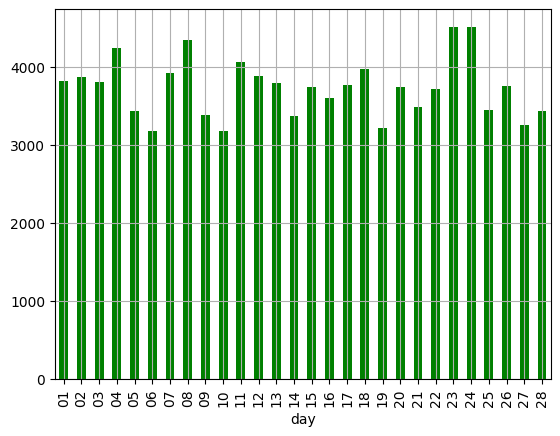

In [568]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

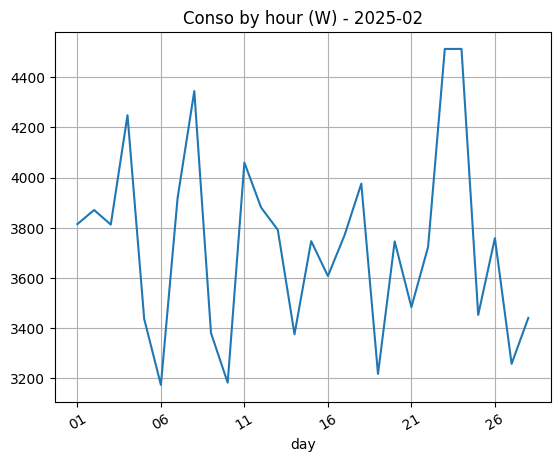

In [569]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [570]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [571]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3815,3815,3815
02,3871,3871,3871
03,3813,3813,3813
04,4249,4249,4249
05,3437,3437,3437
06,3174,3174,3174
07,3919,3919,3919
08,4345,4345,4345
09,3381,3381,3381


In [572]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [573]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [574]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-06,86631,86631,86631
2024-07,99405,99405,99405
2024-08,117324,117324,117324
2024-09,69750,69750,69750
2024-10,73556,73556,73556
2024-11,108501,108501,108501
2024-12,113787,113787,113787
2025-01,113585,113585,113585
2025-02,104507,104507,104507


In [575]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [576]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [577]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
03/06/24,1806
04/06/24,3313
05/06/24,3487
06/06/24,3179
07/06/24,2923
...,...
28/03/25,3489
29/03/25,3842
30/03/25,4002


In [578]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,1619,2.22,1.619,2223.594812,1619,2024-06-03 12:44:28.583575,03/06/24,12,2024-06,03
1,1620,2.22,1.620,2222.222222,3239,2024-06-03 12:44:30.203575,03/06/24,12,2024-06,03
2,1621,2.22,1.621,2220.851326,4860,2024-06-03 12:44:31.824575,03/06/24,12,2024-06,03
3,1618,2.22,1.618,2224.969098,6478,2024-06-03 12:44:33.442575,03/06/24,12,2024-06,03
4,1624,2.22,1.624,2216.748768,8102,2024-06-03 12:44:35.066575,03/06/24,12,2024-06,03
...,...,...,...,...,...,...,...,...,...,...
999995,1568,2.30,1.568,2295.918367,26082273915,2025-04-01 09:49:00.879575,01/04/25,09,2025-04,01
999996,1567,2.30,1.567,2297.383535,26082275482,2025-04-01 09:49:02.446575,01/04/25,09,2025-04,01
999997,1574,2.29,1.574,2287.166455,26082277056,2025-04-01 09:49:04.020575,01/04/25,09,2025-04,01
999998,19152,0.19,19.152,187.969925,26082296208,2025-04-01 09:49:23.172575,01/04/25,09,2025-04,01


In [579]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
03/06/24 12    0       03/06/24    12  2.22
               1       03/06/24    12  2.22
               2       03/06/24    12  2.22
               3       03/06/24    12  2.22
               4       03/06/24    12  2.22
...                         ...   ...   ...
01/04/25 09    999995  01/04/25    09  2.30
               999996  01/04/25    09  2.30
               999997  01/04/25    09  2.29
               999998  01/04/25    09  0.19
               999999  01/04/25    09  0.13

[1000000 rows x 3 columns]

In [580]:
groupallbyday.indices.keys()

dict_keys(['03/06/24', '04/06/24', '05/06/24', '06/06/24', '07/06/24', '08/06/24', '09/06/24', '10/06/24', '11/06/24', '12/06/24', '13/06/24', '14/06/24', '15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/0

In [581]:
groupallbydayhours.indices.keys()

dict_keys([('03/06/24', '12'), ('03/06/24', '13'), ('03/06/24', '14'), ('03/06/24', '15'), ('03/06/24', '16'), ('03/06/24', '17'), ('03/06/24', '18'), ('03/06/24', '19'), ('03/06/24', '20'), ('03/06/24', '21'), ('03/06/24', '22'), ('03/06/24', '23'), ('04/06/24', '12'), ('04/06/24', '13'), ('04/06/24', '14'), ('04/06/24', '15'), ('04/06/24', '16'), ('04/06/24', '17'), ('04/06/24', '18'), ('04/06/24', '19'), ('04/06/24', '20'), ('04/06/24', '21'), ('04/06/24', '22'), ('04/06/24', '23'), ('04/06/24', '00'), ('04/06/24', '01'), ('04/06/24', '02'), ('04/06/24', '03'), ('04/06/24', '04'), ('04/06/24', '05'), ('04/06/24', '06'), ('04/06/24', '07'), ('04/06/24', '08'), ('04/06/24', '09'), ('04/06/24', '10'), ('04/06/24', '11'), ('05/06/24', '12'), ('05/06/24', '13'), ('05/06/24', '14'), ('05/06/24', '15'), ('05/06/24', '16'), ('05/06/24', '17'), ('05/06/24', '18'), ('05/06/24', '19'), ('05/06/24', '20'), ('05/06/24', '21'), ('05/06/24', '22'), ('05/06/24', '23'), ('05/06/24', '00'), ('05/06/2

In [582]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
03/06/24,1806,1806
04/06/24,3313,3313
05/06/24,3487,3487
06/06/24,3179,3179
07/06/24,2923,2923
...,...,...
28/03/25,3489,3489
29/03/25,3842,3842
30/03/25,4002,4002


In [583]:
grp_by_day['kWh'].cumsum()

days
03/06/24       1806
04/06/24       5119
05/06/24       8606
06/06/24      11785
07/06/24      14708
             ...   
28/03/25     987662
29/03/25     991504
30/03/25     995506
31/03/25     998917
01/04/25    1000000
Name: kWh, Length: 303, dtype: int64

In [584]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
03/06/24 12      55
         13     147
         14     202
         15     330
         16     146
...             ...
01/04/25 05     103
         06     101
         07      92
         08     104
         09     139

[7246 rows x 1 columns]

In [585]:
grp_by_dayhours['kWh'].cumsum()

days      hours
03/06/24  12            55
          13           202
          14           404
          15           734
          16           880
                    ...   
01/04/25  05        999564
          06        999665
          07        999757
          08        999861
          09       1000000
Name: kWh, Length: 7246, dtype: int64

In [586]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
03/06/24 12      55      55    NaN
         13     147     202   92.0
         14     202     404   55.0
         15     330     734  128.0
         16     146     880 -184.0
...             ...     ...    ...
01/04/25 05     103     647   -1.0
         06     101     748   -2.0
         07      92     840   -9.0
         08     104     944   12.0
         09     139    1083   35.0

[7246 rows x 3 columns]

In [587]:
today, grp_by_dayhours.loc[today]

('01/04/25',
        kWh  cumsum  diff
 hours                   
 00     125     125   NaN
 01     104     229 -21.0
 02     106     335   2.0
 03     105     440  -1.0
 04     104     544  -1.0
 05     103     647  -1.0
 06     101     748  -2.0
 07      92     840  -9.0
 08     104     944  12.0
 09     139    1083  35.0)

Text(0.5, 1.0, 'Cumul journalier')

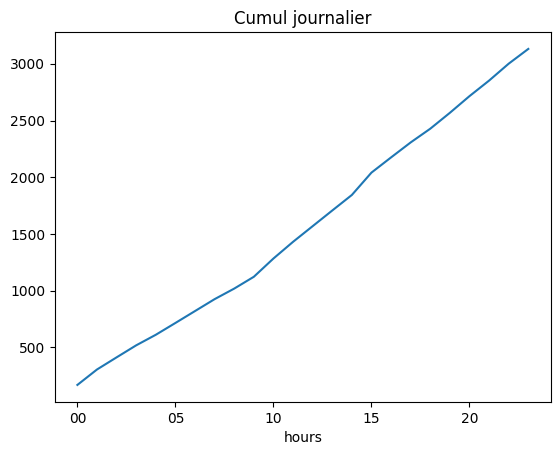

In [588]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

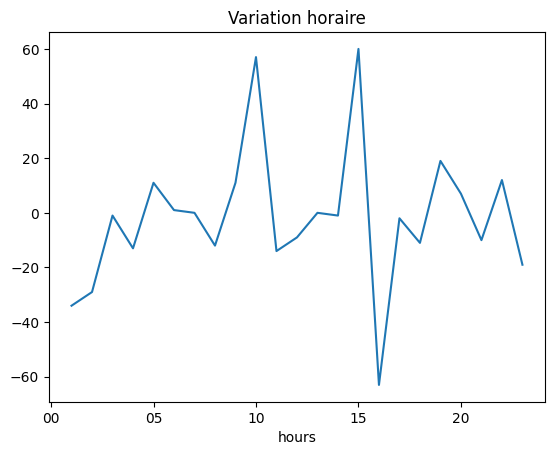

In [589]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [590]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [591]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.761617
min        1.083000
25%        3.124000
50%        3.472000
75%        3.779500
max        4.838000
Name: kWh, dtype: float64

In [592]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '303 days')

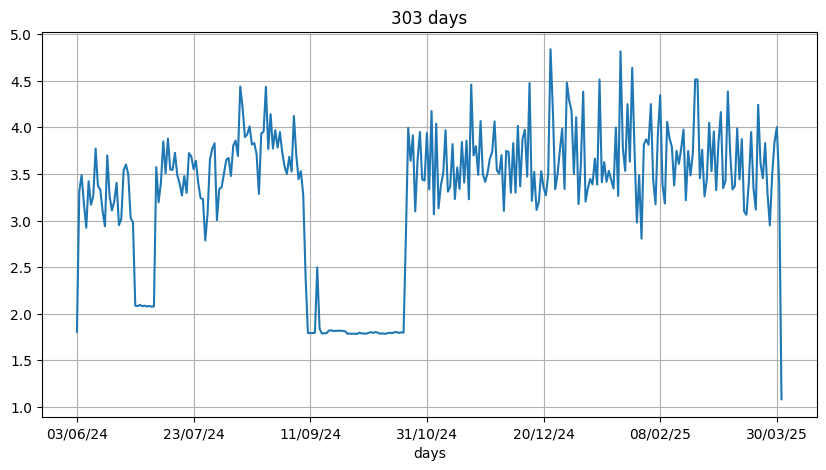

In [593]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

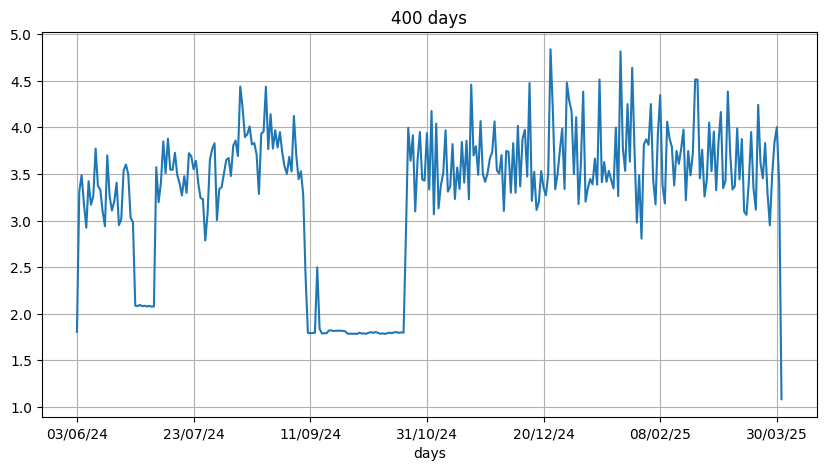

In [594]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [595]:
df_grp['kWh']

days
03/06/24    1.806
04/06/24    3.313
05/06/24    3.487
06/06/24    3.179
07/06/24    2.923
            ...  
28/03/25    3.489
29/03/25    3.842
30/03/25    4.002
31/03/25    3.411
01/04/25    1.083
Name: kWh, Length: 303, dtype: float64

In [596]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.761617
min,1.083000
25%,3.124000
50%,3.472000
75%,3.779500
max,4.838000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

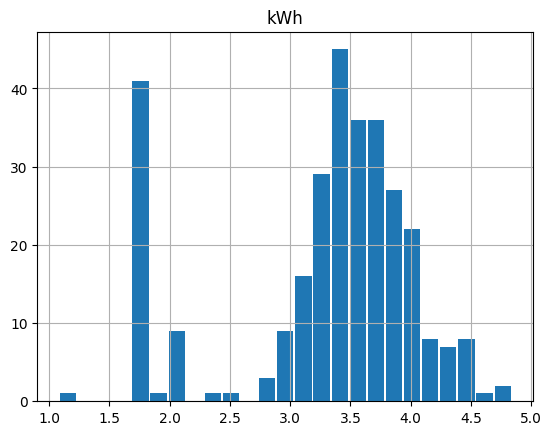

In [597]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [598]:
df_grp.tail(span)['kWh']

days
03/06/24    1.806
04/06/24    3.313
05/06/24    3.487
06/06/24    3.179
07/06/24    2.923
            ...  
28/03/25    3.489
29/03/25    3.842
30/03/25    4.002
31/03/25    3.411
01/04/25    1.083
Name: kWh, Length: 303, dtype: float64

# Conso par heure

In [599]:
day

'01/04/25'

In [600]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,125,125,NaN
01,104,229,-21.0
02,106,335,2.0
03,105,440,-1.0
04,104,544,-1.0
05,103,647,-1.0
06,101,748,-2.0
07,92,840,-9.0
08,104,944,12.0


In [601]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


10

In [602]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 11)

In [603]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [604]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [605]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [606]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [607]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 00 to 09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     10 non-null     int64  
 1   cumsum  10 non-null     int64  
 2   diff    9 non-null      float64
 3   days    10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0+ bytes


In [608]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [609]:
day

'01/04/25'

In [610]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,125,125,NaN,1.0
01,104,229,-21.0,2.0
02,106,335,2.0,3.0
03,105,440,-1.0,4.0
04,104,544,-1.0,5.0
05,103,647,-1.0,6.0
06,101,748,-2.0,7.0
07,92,840,-9.0,8.0
08,104,944,12.0,9.0


Text(0.5, 1.0, '01/04/25')

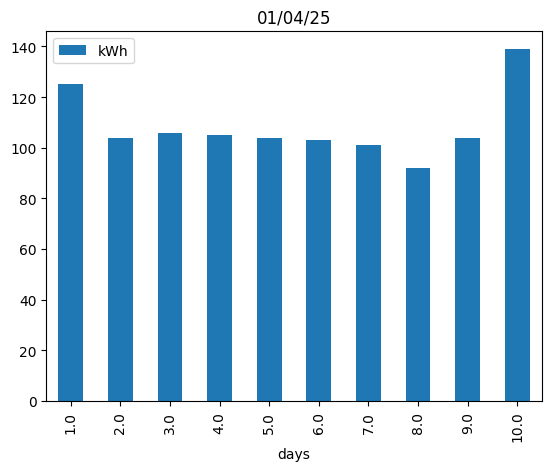

In [611]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [612]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'], dtype='object', name='hours')

# Conso du jour


In [613]:

grp_by_dayhours.count()

kWh       7246
cumsum    7246
diff      6943
days        10
dtype: int64

In [614]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00     166
01     136
02     134
03     136
04     113
05     109
06     110
07     108
08     108
09     109
10     110
11     100
12     167
13     142
14     139
15     133
16    1013
17     530
18     136
19     211
20     168
21     237
22     243
23     280
Name: kWh, dtype: int64

In [615]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [616]:
df_grp.tail(7)['kWh']

days
26/03/25    3.297
27/03/25    2.948
28/03/25    3.489
29/03/25    3.842
30/03/25    4.002
31/03/25    3.411
01/04/25    1.083
Name: kWh, dtype: float64

            kWh
days           
01/04/25  1.083


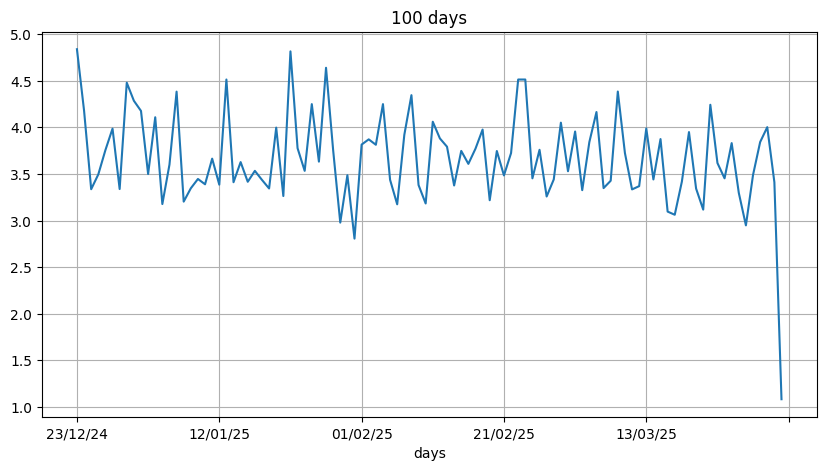

In [617]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [618]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

88.33847188949585


# Today

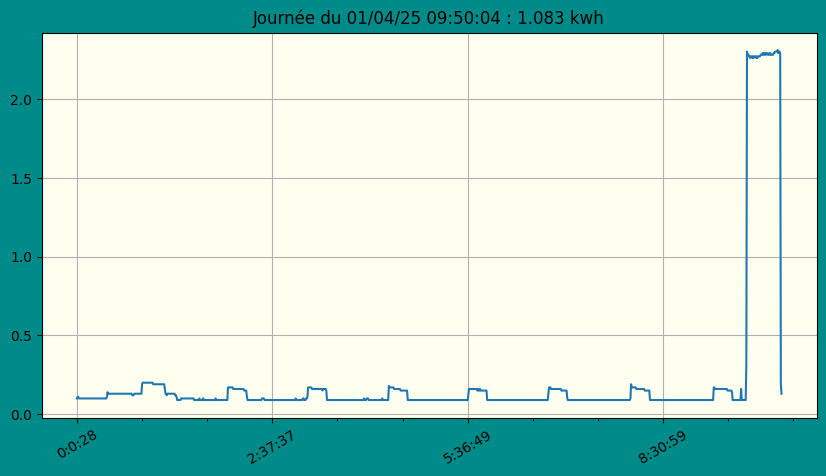

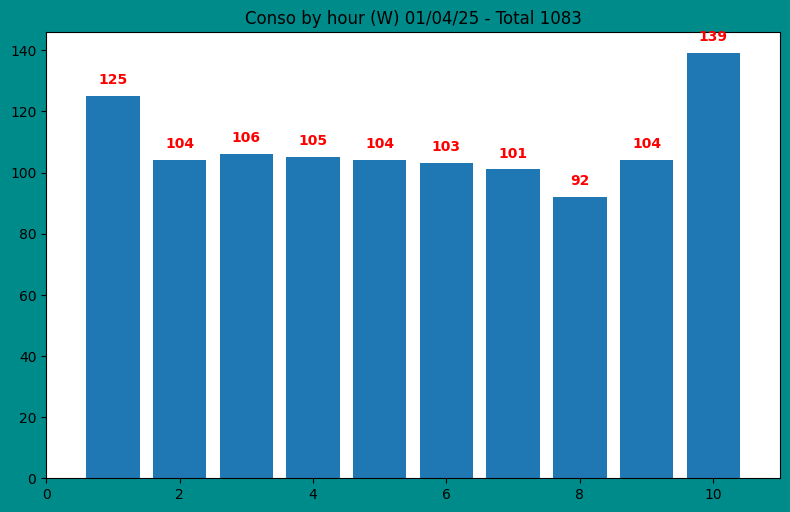

In [619]:
show(today,bgcolor='ivory')
conso_by_hour(today)

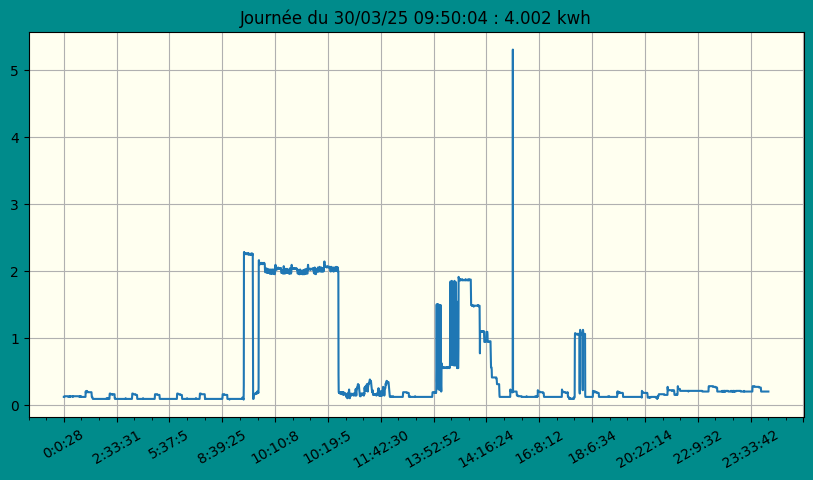

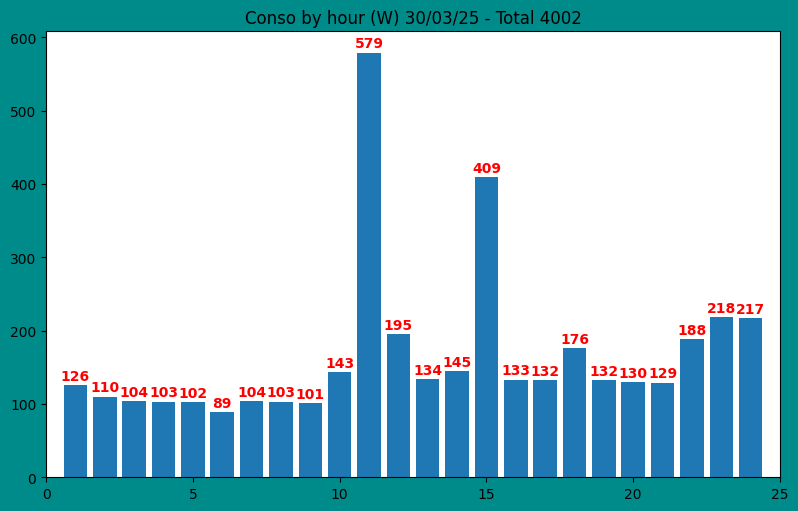

In [620]:
day = '30/03/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4838)

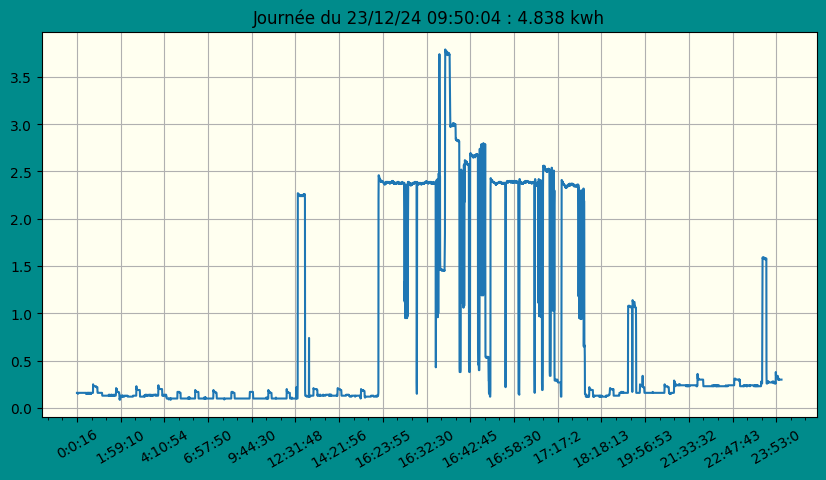

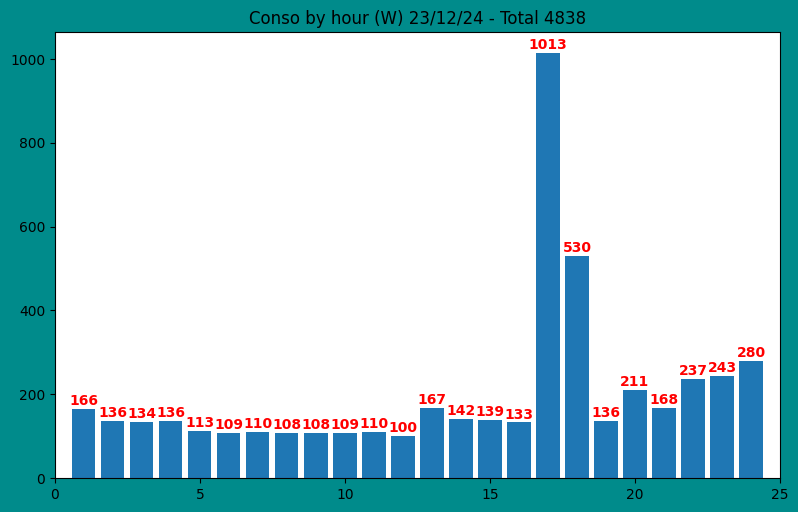

In [621]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

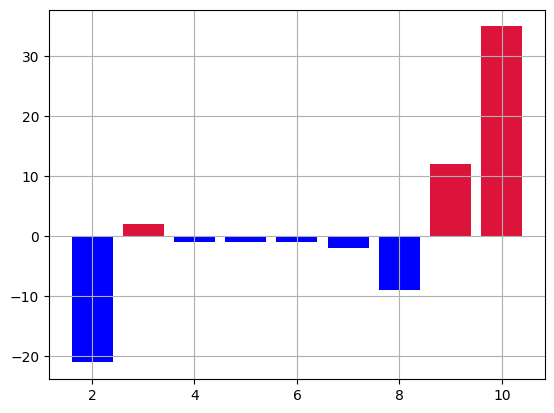

In [622]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

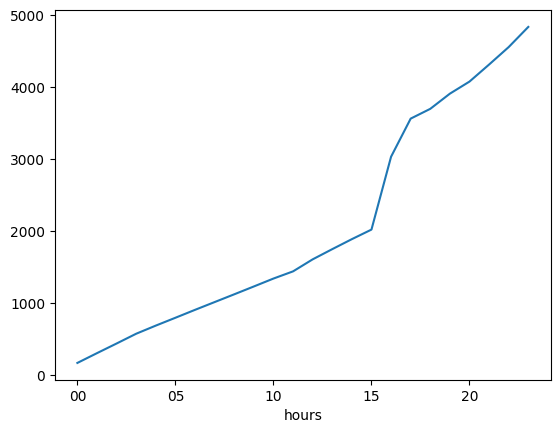

In [623]:
data.cumsum().plot()


<Axes: xlabel='hours'>

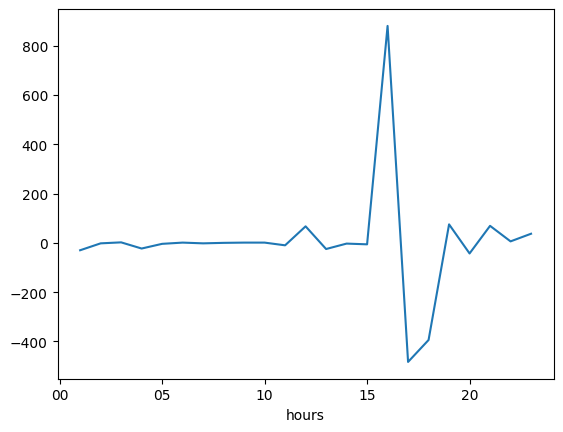

In [624]:
# evolution par heure
data.diff().plot()

In [625]:
data.diff().describe()

count     23.000000
mean       4.956522
std      231.861926
min     -483.000000
25%      -16.500000
50%       -2.000000
75%        4.000000
max      880.000000
Name: kWh, dtype: float64

<Axes: >

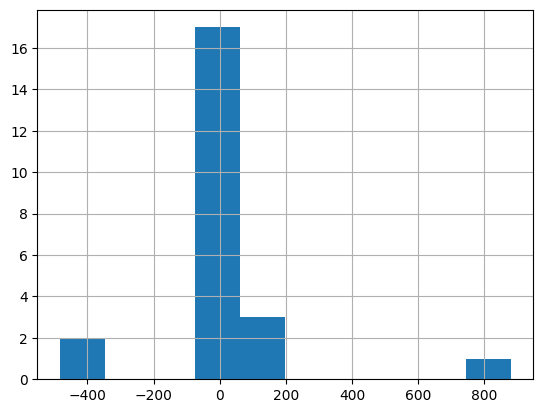

In [626]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [627]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [628]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('23/12/24', None)

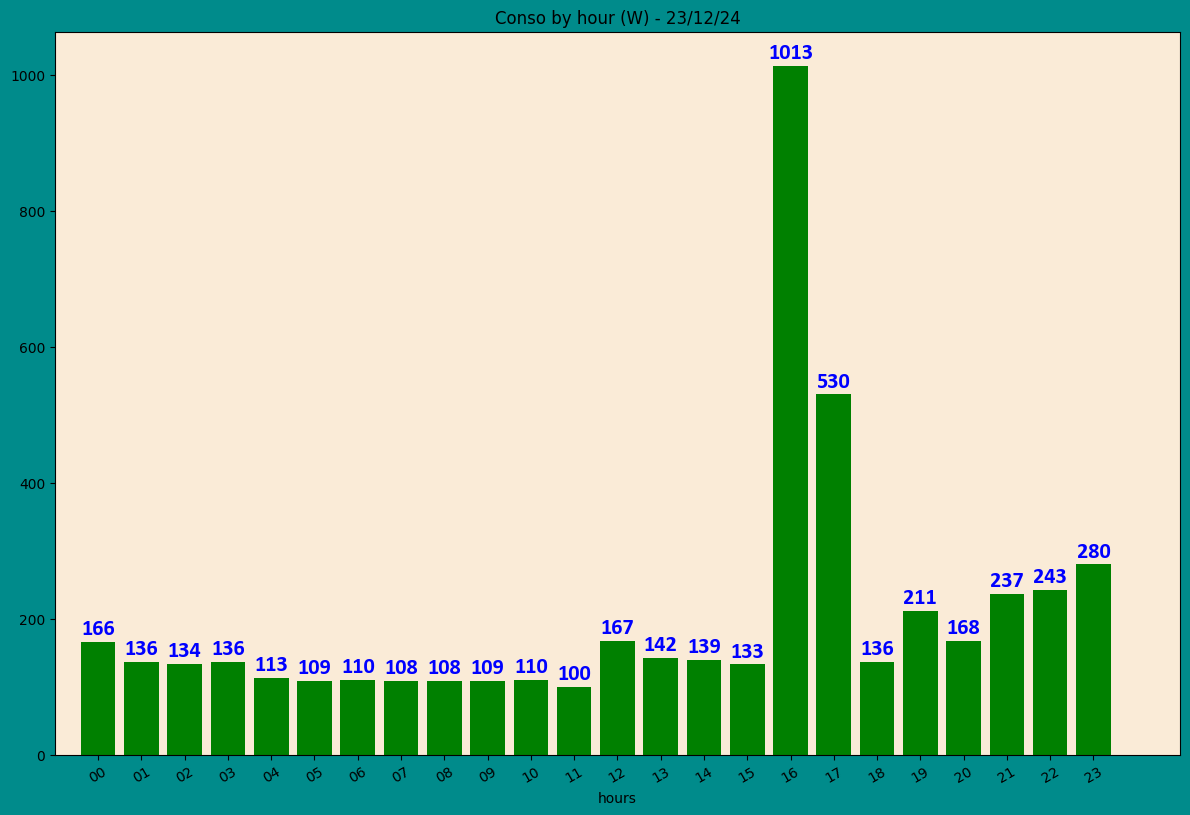

In [629]:
day,conso_byhour(day)

In [630]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


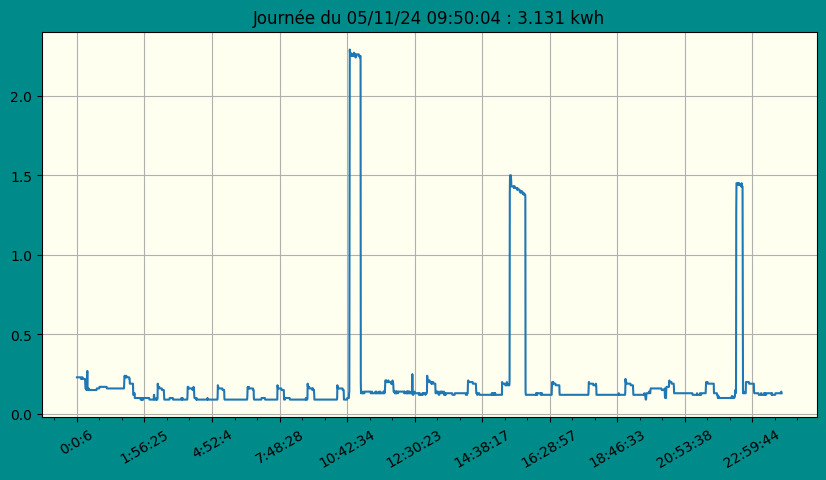

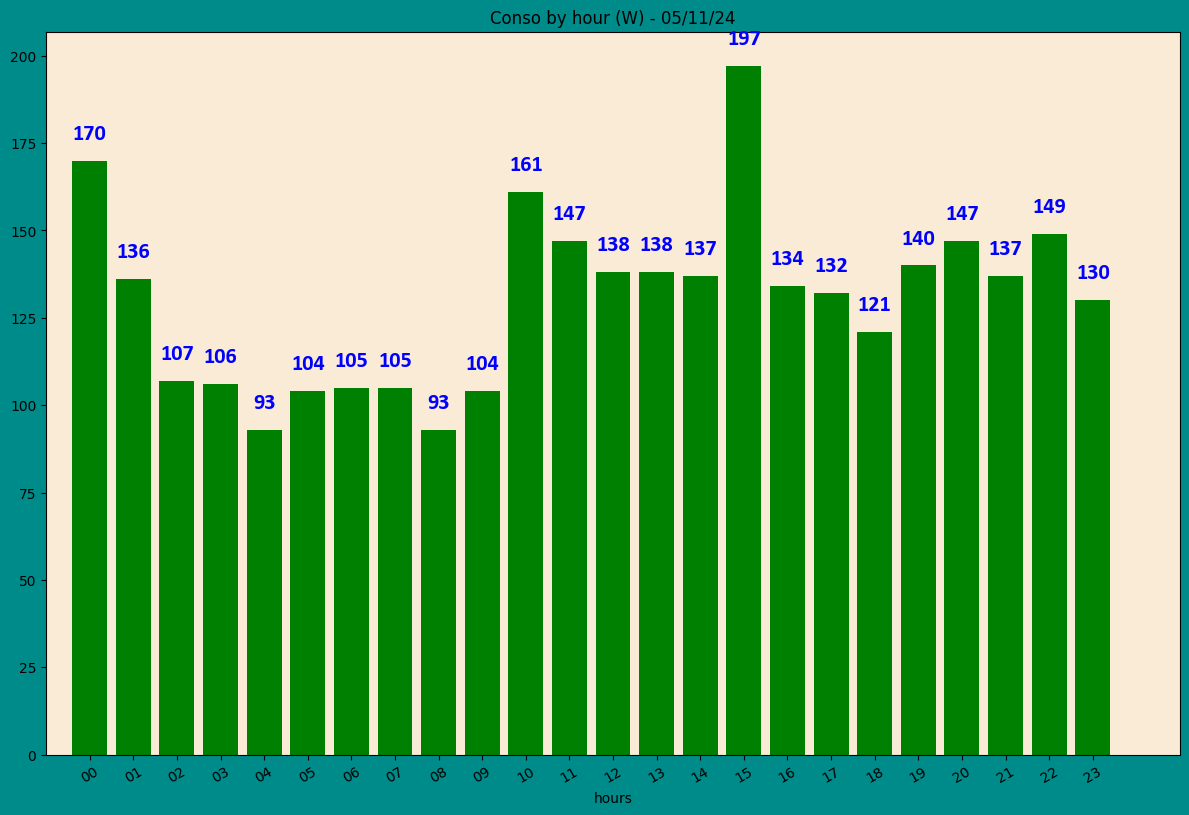

In [631]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [632]:
month

,day,hours,months,kWh
782539,01,00,2025-02,0.14
782540,01,00,2025-02,0.14
782541,01,00,2025-02,0.14
782542,01,00,2025-02,0.15
782543,01,00,2025-02,0.14
...,...,...,...,...
887041,28,23,2025-02,0.11
887042,28,23,2025-02,0.11
887043,28,23,2025-02,0.11
887044,28,23,2025-02,0.11


In [633]:
month.describe()


,kWh
count,104507.000000
mean,0.334549
std,0.555034
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

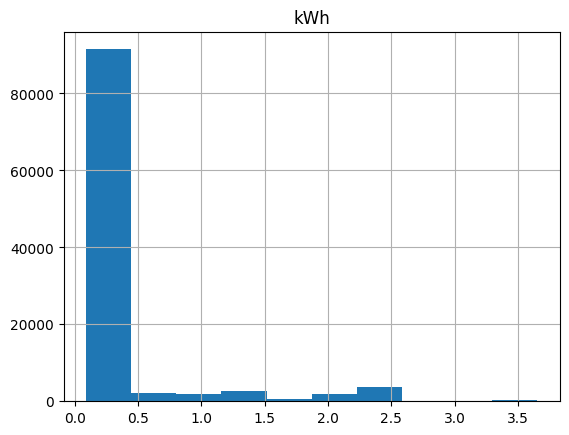

In [634]:
month.hist()

<Axes: >

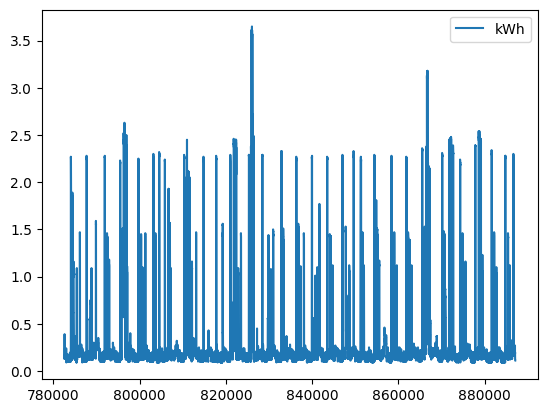

In [635]:
month.plot()

In [636]:
# index with max conso in this month
month.idxmax().kWh

np.int64(826039)

In [637]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       883605
hours     786181
months    782539
kWh       826039
dtype: int64

In [638]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [639]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
03/06/24 12      55      55    NaN   NaN
         13     147     202   92.0   NaN
         14     202     404   55.0   NaN
         15     330     734  128.0   NaN
         16     146     880 -184.0   NaN
...             ...     ...    ...   ...
01/04/25 05     103     647   -1.0   6.0
         06     101     748   -2.0   7.0
         07      92     840   -9.0   8.0
         08     104     944   12.0   9.0
         09     139    1083   35.0  10.0

[7246 rows x 4 columns]

In [640]:
month

,day,hours,months,kWh
782539,01,00,2025-02,0.14
782540,01,00,2025-02,0.14
782541,01,00,2025-02,0.14
782542,01,00,2025-02,0.15
782543,01,00,2025-02,0.14
...,...,...,...,...
887041,28,23,2025-02,0.11
887042,28,23,2025-02,0.11
887043,28,23,2025-02,0.11
887044,28,23,2025-02,0.11


In [641]:
month.idxmax()


day       883605
hours     786181
months    782539
kWh       826039
dtype: int64

In [642]:
month.loc[month.idxmax().kWh]


day            12
hours          14
months    2025-02
kWh          3.65
Name: 826039, dtype: object

In [643]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       145
          01       114
          02       112
          03        97
          04       111
          05       112
          06       110
          07        97
          08       110
          09       120
          10       181
          11       133
          12       149
          13       144
          14       200
          15       140
          16       191
          17       161
          18       148
          19       142
          20       165
          21       226
          22       173
          23       160
Name: kWh, dtype: int64

In [644]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'21'

<Axes: xlabel='days,hours'>

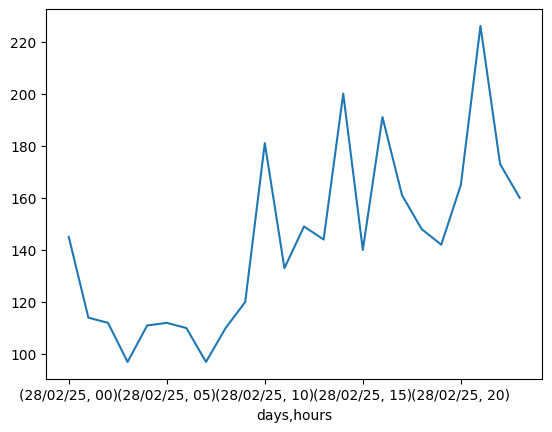

In [645]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [646]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [647]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [648]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [649]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB